In [2]:
#import dependencies
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline
tf.__version__

'1.14.0'

In [7]:
dataset_path = "./chest-xray-pneumonia/chest_xray/chest_xray/"

In [8]:
# We have 3 datasets: train, validation and test

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

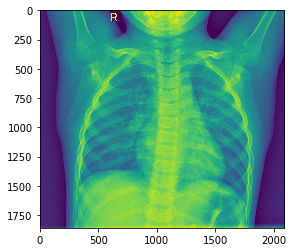

In [9]:
# Let's visualize some an example in the training set
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

In [10]:
'''
Mandatory:
dataset: string, dataset from where we extract images
category: string, category within the dataset (NORMAL, PNEUMONIA)

Optional:
labeled: boolean, determine if images should be labeled
sample_size: int, number of images to display
'''
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  full_path = dataset_path + subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)

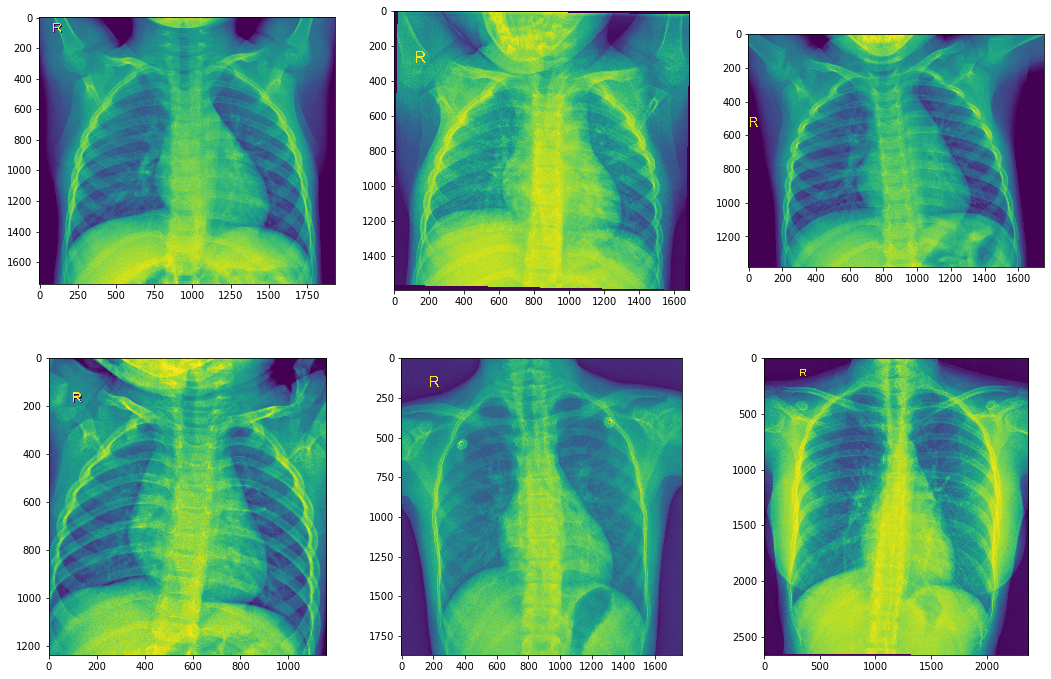

In [11]:
# Calling the above function
plot_img("train", "NORMAL")

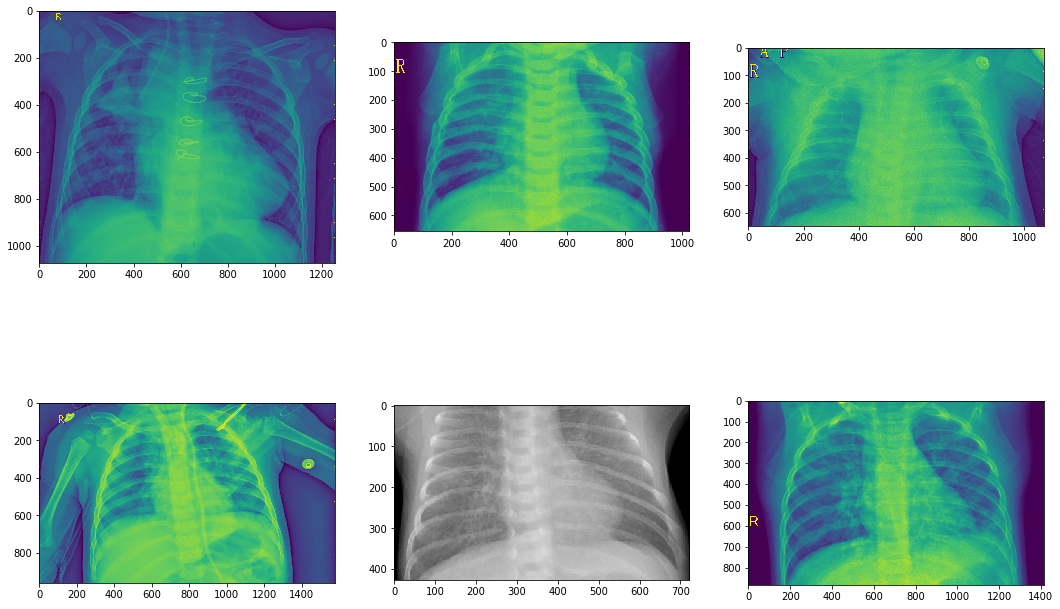

In [12]:
# With pneumonia cases
plot_img("train", "PNEUMONIA")

In [13]:
def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()

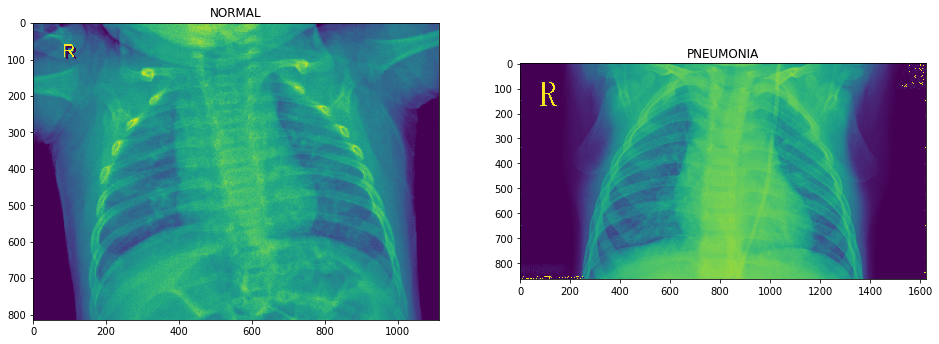

In [14]:
# Let's compare one image showasing pneumonia and one normal
compare_img("train", labeled = True)

# Building the model
Loading the pre-trained model (InceptionV3)¶

In [15]:
IMG_SHAPE = (150, 150, 3)

In [16]:
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 16s 0us/step


# Base architecture of the inceptionV3 model

In [17]:
base_model.summary() # This is quite a complex architecture

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Freezing the base model

In [19]:
base_model.trainable = False

In [20]:
#Defining the custom head for our network
base_model.output

<tf.Tensor 'mixed10/concat:0' shape=(?, 3, 3, 2048) dtype=float32>

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [22]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(?, 2048) dtype=float32>

In [23]:
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

# Defining the model

In [26]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

# Compiling the model

In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [28]:
#Creating Data Generators
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [29]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [30]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 16 images belonging to 2 classes.


In [31]:
test_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 624 images belonging to 2 classes.


# Training the model

In [32]:
model.fit_generator(train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41/41 [==============================] - 228s 6s/step - loss: 0.5244 - acc: 0.7765 - val_loss: 0.8110 - val_acc: 0.6875
Epoch 2/5
41/41 [==============================] - 203s 5s/step - loss: 0.3362 - acc: 0.8702 - val_loss: 1.4565 - val_acc: 0.6875
Epoch 3/5
41/41 [==============================] - 185s 5s/step - loss: 0.2772 - acc: 0.8911 - val_loss: 1.5562 - val_acc: 0.6875
Epoch 4/5
41/41 [==============================] - 185s 5s/step - loss: 0.2399 - acc: 0.9045 - val_loss: 1.8114 - val_acc: 0.6250
Epoch 5/5
41/41 [==============================] - 190s 5s/step - loss: 0.2187 - acc: 0.9187 - val_loss: 1.3183 - val_acc: 0.7500


In [35]:
#model.fit_generator(train_generator, epochs = 5, validation_data = valid_generator)
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.75


# Plotting the results

In [36]:
#Note on model prediction:
#0 => pneumonia
#1 => normal
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

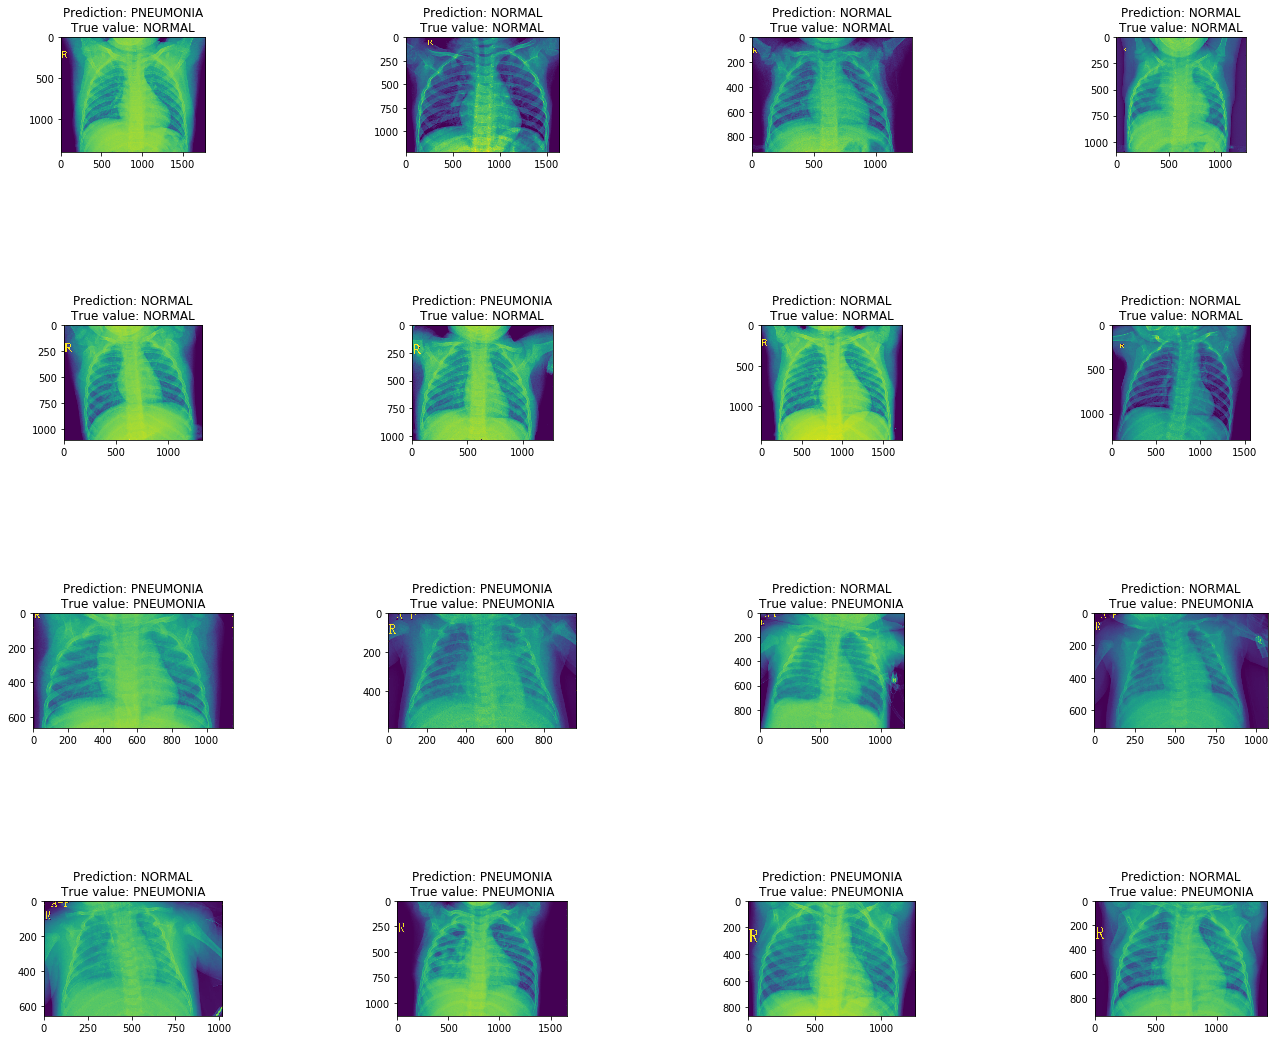

In [37]:
compare_results(validation_dir, valid_generator)

In [38]:
#Saving the model

import json
# serialize model to JSON
model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [39]:
#Un-freeze a few top layers from the model
base_model.trainable = True
print("Number of layers in the base model: {}".format(len(base_model.layers)))

Number of layers in the base model: 311


In [40]:
# Defining the unfreezing starting point
fine_tune_at = 200

In [41]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [42]:
#Compiling the model for fine tuning
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [43]:
#Fine tuning
model.fit_generator(generator = train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
41/41 [==============================] - 276s 7s/step - loss: 0.1438 - acc: 0.9434 - val_loss: 2.4838 - val_acc: 0.6875
Epoch 2/5
41/41 [==============================] - 241s 6s/step - loss: 0.0272 - acc: 0.9912 - val_loss: 5.6672 - val_acc: 0.5625
Epoch 3/5
41/41 [==============================] - 247s 6s/step - loss: 0.0097 - acc: 0.9965 - val_loss: 4.6792 - val_acc: 0.5000
Epoch 4/5
41/41 [==============================] - 243s 6s/step - loss: 0.0073 - acc: 0.9981 - val_loss: 5.8819 - val_acc: 0.4375
Epoch 5/5
41/41 [==============================] - 244s 6s/step - loss: 0.0081 - acc: 0.9977 - val_loss: 7.3462 - val_acc: 0.5000


In [44]:
#Evaluating the fine tuning
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

Validation accuracy after fine tuning: 0.5


# Plotting the new results

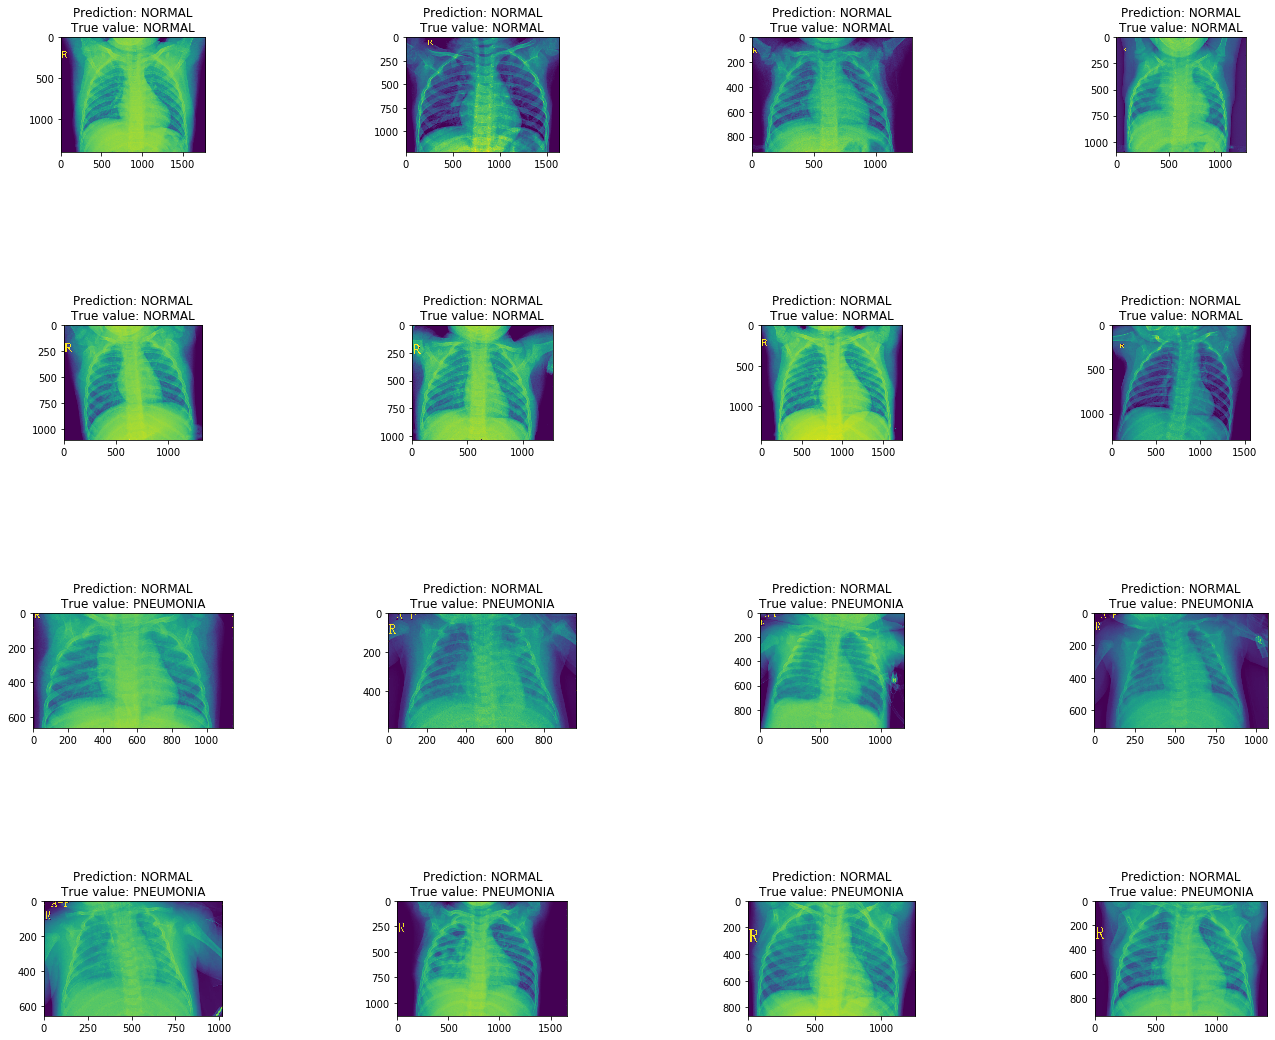

In [45]:
compare_results(validation_dir, valid_generator)